In [1]:
!pip install pymystem3

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords as nltk_stopwords
import os
import requests
from pathlib import Path
import nltk
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import pymorphy2
from collections import Counter
import pymystem3 
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from sklearn.metrics.pairwise import cosine_similarity
import scipy as sp


In [2]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Error loading punkt: <urlopen error [Errno 11002]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11002]
[nltk_data]     getaddrinfo failed>


False

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train1 = pd.read_csv('train.csv')

### Количество слов

In [23]:
train['question'].apply(lambda x: len(x.split(' '))).sum() + train['answer'].apply(lambda x: len(x.split(' '))).sum()

56653616

In [24]:
train['question']

0                                     Что в доме Облонских?.
1          Facebook блокировка, как можно узнать причину?...
2                         Что можно готовить на пост Марии?.
3          Изменить голос в программе.Нужно простую запис...
4          Мне кажется, в 95 лет жизнь только начинается....
                                 ...                        
1344171    ПОЙДЕТ ЛИ ПЕРВЫЙ ASSASIN"S CREED НА ТАКОЙ ПК.п...
1344172    Собака вялая что делать? Сегодня мама ее взяла...
1344173    Помогите пожалуйста Как ответить человеку если...
1344174        Любовь: что остаётся, когда угасает страсть?.
1344175                     Удобный мужчина - это какой?))).
Name: question, Length: 1344176, dtype: object

#### видим что классы не сбаласированны

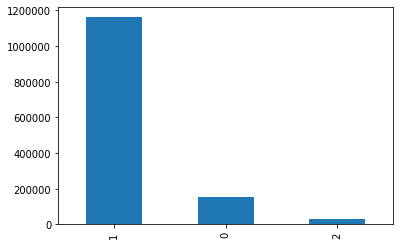

In [25]:
targets = train.target.unique()
train.target.value_counts().plot(kind='bar')

In [26]:
train.target.value_counts()

1    1161217
0     151538
2      31421
Name: target, dtype: int64

## Preprocessing

Убираем стопслова, знаки пунктуации переводим текст в нижний регистр

In [27]:
russian_stopwords = stopwords.words("russian")

In [6]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [5]:
#Считаем время
from tqdm import tqdm
tqdm.pandas(desc="my bar!")

C:\Users\Andrew\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [30]:
#Преобразуем наш текст, сделав попытки с библиотеками для лемматизации время для предобработки данных составляло слишком
#много (минимум 200 часов, а библиотеки с поддержкой гпу ) 
train['question'] = train['question'].progress_apply(lambda x: preprocess_text(x))


my bar!: 100%|██████████| 1344176/1344176 [08:03<00:00, 2782.05it/s]


In [31]:
#
train['answer'] = train['answer'].apply(lambda x: preprocess_text(x))

### Train Test Split

In [32]:
X_train, X_test= train_test_split(train, test_size=0.1)

## TF IDF реализация

Находим tfidf представление вопросов и ответов, пробуем разные варианты гиперпараметров чтобы максимизировать accuracy, строим логистическую регресию на наших параметрах

In [33]:
%%time
#Настраиваем векторайзер
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, max_features=30000)
#Строим векторное представление слов
X_train_features = tf_vect.fit_transform(X_train['question'] + X_train['answer'])

Wall time: 5min 16s


In [34]:
#Обучаем линейный классификатор
logreg = linear_model.LogisticRegression(n_jobs=3, C=1e5)
logreg = logreg.fit(X_train_features, X_train['target'])

In [35]:
#Преобразуем тестовую выборку
X_test_features = tf_vect.transform(X_test['question'] + X_test['answer'])

In [36]:
# Строим прогноз
prediction = logreg.predict(X_test_features)

In [37]:
accuracy_score(X_test['target'], prediction)

0.8661935157493788

Пробуем сделать ресемплинг результатов чтобы улучшить качество прогнозной модели, для этого андерсемплим класс 1 до размера класса 0 и оверсемплим класс 2 до размера класса 0. Проводим все теже шаги что и в предыдущей модели для новой выборке

In [132]:
X_train_class_2 = X_train[X_train['target'] == 2]
X_train_class_1 = X_train[X_train['target'] == 1]
X_train_class_0 = X_train[X_train['target'] == 0]

In [133]:
class1, class0, class2 = X_train.target.value_counts()

In [165]:
class1_under = X_train_class_1.sample(class0)
class2_under = X_train_class_2.sample(class0, replace=True)
X_train_u = pd.concat([class2_under,class1_under,X_train_class_0])

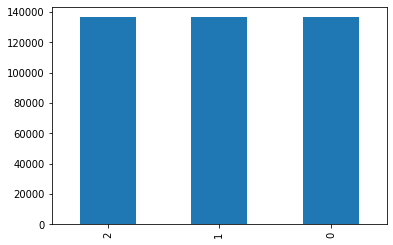

In [166]:
X_train_u.target.value_counts().plot(kind='bar')

In [209]:
%%time
tf_vect1 = TfidfVectorizer(
    min_df=2, max_df=0.5, tokenizer=nltk.word_tokenize,
    preprocessor=None)
X_train_u_features = tf_vect1.fit_transform(X_train_u['question'] + X_train_u['answer'])

Wall time: 1min 56s


In [210]:
logreg1 = linear_model.LogisticRegression(n_jobs=3, C=1e5)
logreg1 = logreg1.fit(X_train_u_features, X_train_u['target'])

In [211]:
X_test_u_features = tf_vect1.transform(X_test['question'] + X_test['answer'])

In [212]:
prediction1 = logreg1.predict(X_test_u_features)
accuracy_score(X_test['target'], prediction1)

0.4526253924325611

In [213]:
X_test['target'].value_counts()

1    116166
0     15088
2      3164
Name: target, dtype: int64

In [214]:
pd.DataFrame(prediction1)[0].value_counts()

1    59309
0    53638
2    21471
Name: 0, dtype: int64

## Question answering

In [189]:
!pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


Реализация на tfidf, находим наиболее похожую пару вопрос ответ в нашей базе данных с помощью векторной меры близости преобразованного вектора нашего вопроса и вектора вопроса и ответа, строим прогноз на его полезность с помощью ранее обученной логистической регресии и  на его основе выдаем ответ максимально полезный ответ, если присутствует много одинаковых по полезности ответов выбираем случайный

In [38]:
def ask_question(question):
    query_vect = tf_vect.transform([question])
    similarity = cosine_similarity(query_vect, X_train_features)
    max_similarity = np.argwhere(similarity == np.amax(similarity, axis=None))[:,1]
    predict2 = logreg.predict(X_train_features[max_similarity.T,:])
    max_predicted = max_similarity[np.argwhere(predict2 == np.min(predict2, axis=None)).T]
    print('Вопрос:', question)
    print(predict2)
    print('Ответ:', train1.iloc[X_train.iloc[np.random.choice(max_similarity)]['id']]['answer'])

In [42]:
def answer(question):
    query_vect = tf_vect.transform([question])
    similarity = cosine_similarity(query_vect, X_train_features)
    max_similarity = np.argwhere(similarity == np.amax(similarity, axis=None))[:,1]
    predict2 = logreg.predict(X_train_features[max_similarity.T,:])
    max_predicted = max_similarity[np.argwhere(predict2 == np.min(predict2, axis=None)).T]
    return [train1.iloc[X_train.iloc[np.random.choice(max_similarity)]['id']]['answer'], max_predicted]

In [48]:
ask_question('Будет ли Навальный драться против золотова?')

Вопрос: Будет ли Навальный драться против золотова?
[1]
Ответ: Нет


In [9]:
import torch
import torch.nn
from transformers import BertTokenizer,BertModel,AutoTokenizer,DistilBertModel,DistilBertTokenizer
import transformers
import matplotlib.pyplot as plt

In [12]:
if torch.cuda.is_available():        
    device=torch.device("cuda")
    print('There are %d GPU(s) available.' %torch.cuda.device_count())
    print('We will use the GPU:',torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080


На данном датасете можно также придуть более продвинутый анти-спам, так как была замечена замаскированная обсценная лексика, также представляется возможным на исследуемых данных возможно построить модель которая находит конкретный ответ на вопрос из пары слов а не весь ответ из базы: (http://docs.deeppavlov.ai/en/master/features/models/squad.html), также возможно обучить чатбот. Можно построить классификатор по категориям, для более точного определения категории вопроса, так люди сами могут писать не в те категории. 